In [29]:
#import spacy
#from spacy import displacy

import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches

import sklearn
#from sklearn.preprocessing import CategoricalEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from keras.preprocessing.text import text_to_word_sequence

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Activation, Dropout
from keras import layers
from keras.layers import Input, Concatenate
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.models import load_model
from keras import regularizers
from keras.utils import plot_model
import keras.backend as K
K.set_image_data_format('channels_last')
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
from sklearn.metrics import confusion_matrix


In [30]:
# Here are the functions to pre-process the data before feeding it

def split_data(data, training_size=0.8):
  """
  data: Pandas Dataframe
  training_size: proportion of the data to be used for training
  This function splits the data into training_set and test_set based on the given training_size
  Return: train_set and test_set as pandas DataFrame
  """
  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]


In [31]:
# importer le csv, quelques erreurs pouvaient exister 

dataset_path = r'hack_train.csv'
dataset_raw = pd.read_csv(dataset_path, header = 0,sep = ';', error_bad_lines = False,encoding = "ISO-8859-1")

# shuffles the dataset
dataset_raw = dataset_raw.sample(frac=1).reset_index(drop=True)
training_set, test_set = split_data(dataset_raw)

# fits the count vectorizer on training data
count_vec = CountVectorizer()
transformer = TfidfTransformer()

descriptions_training = training_set['description']
descriptions_training.fillna(value='', inplace=True)

count_vec.fit(descriptions_training)

transformer.fit(count_vec.transform(descriptions_training))



/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [32]:
# Using bag of words technique

def process_bag(descriptions):

    x = count_vec.transform(descriptions)
    x = transformer.transform(x)
    
    return x

In [33]:

def create_inputs_outputs(data):
    """
    data: pandas DataFrame, this could be either training_set or test_set
    This function will create input array X from the given dataset and will normalize 'Close' and 'Volume' between 0 and 1
    Return: 
    data.values -> the input except description
    description -> the preprocessed description
    and output  -> the 'sold' booleans
    """

    output = data['sold']

    descriptions = data['description']
    descriptions.fillna(value='', inplace=True)
    descriptions = process_bag(descriptions)
    
    # we have to drop not relevant input and put the description apart
    data = data.drop(['description','UniqueID','sold'],1)

    # here we transform the categorical inputs in one-hot vectors
    for name in (data.columns):
      if name not in ['startprice', 'description']:
        one_hot = pd.get_dummies(data[name], prefix = name)
        data = pd.concat([data, one_hot], axis=1)
        data = data.drop(name,1)

    return data.values, descriptions, output


In [16]:
# divides the dataset into training and test
training_set, test_set = split_data(dataset_raw)

#descriptions = training_set['description']
#descriptions.fillna(value='', inplace=True)
#descriptions = process_bag(descriptions)

#print(descriptions[2])

X_train, D_train, Y_train =  create_inputs_outputs(training_set)
X_test,D_test, Y_test = create_inputs_outputs(test_set)

features_shape = X_train.shape[1]
descriptions_shape = D_train.shape[1]

print(features_shape)
print(descriptions_shape)


29
881


/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [19]:
def modele(l=100, m=50, n=30, o=20, dropout_rate = 0.2):
        input_features = Input((features_shape,), name = 'features')
        input_descriptions = Input((descriptions_shape,), name = 'description')
    
        desc = input_descriptions
        feat = input_features
        
        desc = Dense(int(l), activation='relu')(desc)
        desc = Dropout(dropout_rate)(desc)
        desc = Dense(int(m), activation='relu')(desc)
        
        x = Concatenate(axis = -1)([feat, desc])
        
        x = Dense(int(n), activation='relu')(x)
        x = Dropout(dropout_rate)(x)
        x = Dense(int(o), activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)

        # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
        model = Model(inputs = [input_features, input_descriptions], outputs = x, name='model')
        return model

Train on 1595 samples, validate on 399 samples
Epoch 1/100
1595/1595 [==============================] - 0s 189us/step - loss: 1.9346 - acc: 0.5699 - val_loss: 1.9567 - val_acc: 0.6115
Epoch 2/100
1595/1595 [==============================] - 0s 35us/step - loss: 2.0577 - acc: 0.5624 - val_loss: 1.9543 - val_acc: 0.6115
Epoch 3/100
1595/1595 [==============================] - 0s 35us/step - loss: 1.9669 - acc: 0.5724 - val_loss: 1.9520 - val_acc: 0.6115
Epoch 4/100
1595/1595 [==============================] - 0s 45us/step - loss: 1.9612 - acc: 0.5592 - val_loss: 1.9493 - val_acc: 0.6115
Epoch 5/100
1595/1595 [==============================] - 0s 52us/step - loss: 2.0155 - acc: 0.5611 - val_loss: 1.9480 - val_acc: 0.6115
Epoch 6/100
1595/1595 [==============================] - 0s 30us/step - loss: 2.1282 - acc: 0.5592 - val_loss: 1.9461 - val_acc: 0.6115
Epoch 7/100
1595/1595 [==============================] - 0s 34us/step - loss: 1.9610 - acc: 0.5561 - val_loss: 1.9439 - val_acc: 0.6115


1595/1595 [==============================] - 0s 28us/step - loss: 1.9458 - acc: 0.5661 - val_loss: 1.8496 - val_acc: 0.6115
Epoch 61/100
1595/1595 [==============================] - 0s 40us/step - loss: 1.9251 - acc: 0.5624 - val_loss: 1.8491 - val_acc: 0.6115
Epoch 62/100
1595/1595 [==============================] - 0s 33us/step - loss: 1.9784 - acc: 0.5630 - val_loss: 1.8467 - val_acc: 0.6115
Epoch 63/100
1595/1595 [==============================] - 0s 36us/step - loss: 1.9006 - acc: 0.5680 - val_loss: 1.8436 - val_acc: 0.6115
Epoch 64/100
1595/1595 [==============================] - 0s 35us/step - loss: 1.9117 - acc: 0.5567 - val_loss: 1.8422 - val_acc: 0.6115
Epoch 65/100
1595/1595 [==============================] - 0s 33us/step - loss: 1.9770 - acc: 0.5743 - val_loss: 1.8390 - val_acc: 0.6115
Epoch 66/100
1595/1595 [==============================] - 0s 32us/step - loss: 1.8865 - acc: 0.5693 - val_loss: 1.8377 - val_acc: 0.6115
Epoch 67/100
1595/1595 [==============================

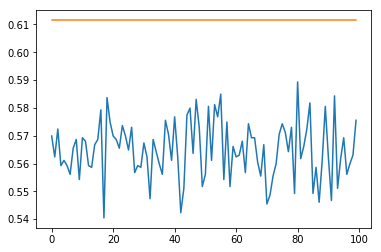

In [41]:
#hyperparam_opt()

modele1 = modele(l=100,m=50,n=30,o=20, dropout_rate=0.2)
modele1.compile(optimizer = SGD(0.00001),loss = "binary_crossentropy", metrics = ["accuracy"])
history = modele1.fit([X_train, D_train.toarray()], y = Y_train, epochs = 100, batch_size = 1000, validation_data = ([X_test,D_test.toarray()], Y_test))
modele1.evaluate(x = [X_test, D_test.toarray()], y = Y_test)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [35]:
D_train.T.shape

(881, 1595)

In [28]:
X_train.shape

(1595, 29)